In [7]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

In [8]:
opti=asb.Opti(cache_filename="soln1.json")


### Constants
# World
g = 9.81  # [m/s^2]
e = 0.7  # Oswald efficiency factor standard for A320

# Structural
mass = 63000  # [kg]
weight = mass * g
weight_fuselage = 20000 * g  # [N] assumed fuselage weight
W_W_coeff1 = 7e-6  # Wing Weight Coefficient 1 [1/m]
W_W_coeff2 = 45.24  # Wing Weight Coefficient 2 [Pa]
ultimate_load_factor = 3.8  # ultimate load factor [-]
airfoil_thickness_fraction = 0.12  # Approx. for SC(2)-0412

# Propulsion
engine_thrust = 105000  # [N]
engine_tsfc = 0.0035  # [kg/m]

# Operating conditions
cruise_alt = 11000  # [m]
service_ceil = 13100  # [m]
atm = asb.atmosphere.Atmosphere(cruise_alt)
cruise_mach = 0.8  # [mach]
cruise_speed = atm.speed_of_sound() * cruise_mach


### Variables
# Main wing
wing_airfoil = asb.Airfoil("sc20412")
wing_sweep = 35
span = opti.variable(init_guess=45, lower_bound=35, upper_bound=50, scale=5)
chord_root = opti.variable(init_guess=3, lower_bound=1, upper_bound=15)
chord_tip = opti.variable(init_guess=1, lower_bound=.5, upper_bound=2)

# Truss wing
truss_span = span / 5
truss_chord_root = 1
truss_chord_tip = 0.5

# Stabs
stab_airfoil = asb.Airfoil("naca0012")
# aoa = opti.variable(init_guess=2, lower_bound=0, upper_bound=10, scale=1)


### Geoemtries
# Main wing
main_wing = asb.Wing(
    name="Main Wing",
    symmetric=True,  # Should this wing be mirrored across the XZ plane?
    xsecs=[  # The wing's cross ("X") sections
        asb.WingXSec(  # Root
            xyz_le=[
                0,
                0,
                1.5,
            ],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
            chord=chord_root,
            # twist=aoa,  # degrees
            airfoil=wing_airfoil  # Airfoils are blended between a given XSec and the next one.
        ),
        asb.WingXSec(  # Tip
            xyz_le=[
                np.sind(wing_sweep) * (span/2),
                span / 2,
                1.5,
            ],
            chord=chord_tip,  # Tip chord is 20% of root chord
            # twist=aoa,
            airfoil=wing_airfoil
        ),
    ],
)
# Truss wing
truss_wing = asb.Wing(
    name="Wing Truss",
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[
                5, 
                0, 
                -1.5
            ],  # Truss connects to fuselage near root
            chord=truss_chord_root,
            airfoil=wing_airfoil,
        ),
        asb.WingXSec(
            xyz_le=[
                5.5,  # A bit inward from wing tip
                truss_span,
                -0.1 + 1.5 # Slight vertical offset to angle the truss
            ],
            chord=truss_chord_tip,
            airfoil=wing_airfoil,
        ),
    ]
)
# Ampenage
horiz_stab = asb.Wing(
    name="Horizontal stab",
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[24, 0, 7],  # Approx. location at rear fuselage
            chord=2.75,            # Larger root chord
            airfoil=stab_airfoil,  # Typically symmetric airfoil like NACA 0012
        ),
        asb.WingXSec(
            xyz_le=[26.5, 5.5, 6.9],  # Apply sweep and slight dihedral
            chord=1.0,                        # Smaller tip chord
            airfoil=stab_airfoil,
        ),
    ]
)
vert_stab = asb.Wing(
    name="Vertical stab",
    symmetric=False,
    xsecs=[
        asb.WingXSec(
            xyz_le=[21, 0, 1.0],  # Root at rear-top of fuselage
            chord=4.0,
            airfoil=stab_airfoil,  # Typically symmetric (e.g., NACA 0012)
        ),
        asb.WingXSec(
            xyz_le=[24.5, 0, 7],  # Add sweep, go upward
            chord=1.5,
            airfoil=stab_airfoil,
        ),
    ]
)
# Engines
left_engine = asb.Propulsor(
    name="Left Engine",
    xyz_c=[1.5, -7, -0.5],  # Approx. underwing, side-mounted
    radius=1,
    length=3.5
)
right_engine = asb.Propulsor(
    name="Right Engine",
    xyz_c=[1.5, 7, -0.5],  # Approx. underwing, side-mounted
    radius=1,
    length=3.5
)
# Fuselage
asb.horizontal
asb.Fuselage()
fuselage = asb.Fuselage(
    name="ACE-1 Fuselage",
    symmetric=True,
    xsecs=[
        asb.FuselageXSec(
            xyz_c=[-13.04-0.196, 0, -0.444],
            radius=0
        ),
        asb.FuselageXSec(
            xyz_c=[-13.04, 0, -0.444],
            radius=0.63842502/2
        ),
        asb.FuselageXSec(
            xyz_c=[-12.74, 0, -0.444],
            radius=1.04048993/2
        ),
        asb.FuselageXSec(
            xyz_c=[-11.727, 0, -0.44427933],
            radius=0.9648
        ),
        asb.FuselageXSec(
            xyz_c=[-10.610, 0, -0.21648632],
            radius=2.95801910/2
        ),
        asb.FuselageXSec(
            xyz_c=[-9.464, 0, -0.13295889],
            radius=1.719
        ),
        asb.FuselageXSec(
            xyz_c=[-7.411, 0, 0],
            radius=1.89
        ),
        asb.FuselageXSec(
            xyz_c=[-6.248, 0, 0],
            radius=1.88           # Constant diameter midsection
        ),
        asb.FuselageXSec(
            xyz_c=[11.25174427, 0, 0],
            radius=1.88           # Constant diameter midsection
        ),
        asb.FuselageXSec(
            xyz_c=[13.3389, 0, 0.0377],
            radius=1.858
        ),
        asb.FuselageXSec(
            xyz_c=[16.1137, 0, 0.20096818],
            radius=1.67718
        ),
        asb.FuselageXSec(
            xyz_c=[18.9266, 0, 0.48167075],
            radius=1.35949
        ),
        asb.FuselageXSec(
            xyz_c=[21.72, 0, 0.90215062],
            radius=0.9021
        ),
        asb.FuselageXSec(
            xyz_c=[26.0569, 0, 1.31256010],
            radius=0.471701
        ),
        asb.FuselageXSec(
            xyz_c=[26.25, 0, 1.31256010],
            radius=0
        )
    ]
)


# Wing weight model
weight_wing_structural = W_W_coeff1 * (
        ultimate_load_factor * main_wing.aspect_ratio() ** 1.5 *
        (weight_fuselage * weight * main_wing.area()) ** 0.5
) / airfoil_thickness_fraction
weight_wing_surface = W_W_coeff2 * main_wing.area()
weight_wing = weight_wing_surface + weight_wing_structural


airplane = asb.Airplane(
    name="ACE-1",
    xyz_ref=[0.25 * chord_root, 0, 0],  # CG location
    wings=[main_wing, truss_wing, horiz_stab, vert_stab],
    fuselages=[fuselage],
    propulsors=[left_engine, right_engine]
)


### Aerodynamics
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=cruise_speed,
        # alpha=5,
    )
)
abu = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=cruise_speed,
        # alpha=5,
    )
)
aero_vlm = vlm.run()
aero_abu = abu.run()

D_induced_vlm = aero_vlm["D"]
D_parasitic_abu = aero_abu["D_profile"]  # Already includes drag from all modeled components
D_total_hybrid = D_induced_vlm + D_parasitic_abu
L_vlm = aero_vlm["L"]  # More accurate lift


### Weight model
weight_wing_structural = W_W_coeff1 * (
        ultimate_load_factor * main_wing.aspect_ratio() ** 1.5 *
        (weight_fuselage * weight * main_wing.area()) ** 0.5
) / airfoil_thickness_fraction
weight_wing_surface = W_W_coeff2 * main_wing.area()
weight_wing = weight_wing_surface + weight_wing_structural


### Constraints and objective
opti.subject_to([
    L_vlm == weight + weight_wing
])
opti.minimize(D_total_hybrid)

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4546982e+04 3.48e+04 1.48e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [9]:
# Output results
sol_main_wing = sol(main_wing)
sol_span = sol(span)
sol_chord_root = sol(chord_root)
sol_chord_tip = sol(chord_tip)

sol_truss_wing = sol(truss_wing)
sol_truss_span = sol_span / 5

sol_lift_vlm = sol(L_vlm)
sol_aero_vlm = sol(aero_vlm)
sol_aero_abu = sol(aero_abu)

# Aircraft dimensions
print("---AIRCRAFT DIMENSIONS---")
print("Reference area (m^2):", sol_main_wing.area() + sol_truss_wing.area())
print("")

print("-MAIN WING-")
print("Wingspan (m):", sol_span)
print("Planform area (m^2):", sol_main_wing.area())
print("Chord Root Length (m):", sol_chord_root)
print("Chord Tip Length (m):", sol_chord_tip)
print(f"Aspect Ratio: {sol_span**2 / sol_main_wing.area():.2f}")
print("Wetted area (m^2):", sol_main_wing.area(type="wetted"))
print("")

print("-TRUSS WING-")
print("Wingspan (m):", sol_span / 5)
print("Planform area (m):", sol_truss_wing.area())
print("Chord Root Length (m):", truss_chord_root)
print("Chord Tip Length (m):", truss_chord_tip)
print("Wetted area (m^2):", sol_truss_wing.area(type="wetted"))
print("")

print("-HORIZ STAB-")
print("MAC (m):", horiz_stab.mean_aerodynamic_chord())
print("Span (m):", horiz_stab.span())
print("Planform area (m^2):", horiz_stab.area())
print("Wetted area (m^2):", horiz_stab.area(type="wetted"))
print("Span (m):", horiz_stab.span())
print("")

print("-VERT STAB-")
print("MAC (m):", vert_stab.mean_aerodynamic_chord())
print("Span (m):", vert_stab.span())
print("Planform area (m^2):", vert_stab.area())
print("Wetted area (m^2):", vert_stab.area(type="wetted"))
print("Span (m):", vert_stab.span())
print("")

print("-FUSELAGE-")
print("Wetted area (m^2):", fuselage.area_wetted())
print("")

# Aerodynamics
print("---AIRCRAFT DIMENSIONS---")
print("Lift [kg]:", sol_lift_vlm / g)
print("Induced Drag (VLM):", sol_aero_vlm["D"])
print("Parasitic Drag Coefficient (AeroBuildup):", sol_aero_abu["CD"])  # Already includes drag from all modeled components)
print("Parasitic Drag (AeroBuildup):", sol_aero_abu["D_profile"])
print("Hybrid Drag [N]:", sol(D_total_hybrid))

---AIRCRAFT DIMENSIONS---
Reference area (m^2): 107.66659807362934

-MAIN WING-
Wingspan (m): 40.31432792282669
Planform area (m^2): 94.81379475185443
Chord Root Length (m): 4.203726927500502
Chord Tip Length (m): 0.4999999922862056
Aspect Ratio: 17.14
Wetted area (m^2): 193.73720352146844

-TRUSS WING-
Wingspan (m): 8.062865584565339
Planform area (m): 12.852803321774918
Chord Root Length (m): 1
Chord Tip Length (m): 0.5
Wetted area (m^2): 26.262699214698515

-HORIZ STAB-
MAC (m): 2.011111111111111
Span (m): 11.001818031580054
Planform area (m^2): 20.6284088092126
Wetted area (m^2): 42.0666897494814
Span (m): 11.001818031580054

-VERT STAB-
MAC (m): 2.9393939393939394
Span (m): 6.0
Planform area (m^2): 16.5
Wetted area (m^2): 33.647790640859284
Span (m): 6.0

-FUSELAGE-
Wetted area (m^2): 390.4733565366253

---AIRCRAFT DIMENSIONS---
Lift [kg]: 68874.65933754842
Induced Drag (VLM): 1862.4737630806953
Parasitic Drag Coefficient (AeroBuildup): 0.01934178193594798
Parasitic Drag (AeroBuil

In [12]:
vlm=sol(vlm)
vlm.draw()
airplane=sol(airplane)
airplane.draw()

Widget(value='<iframe src="http://localhost:51418/index.html?ui=P_0x1439c7b10_4&reconnect=auto" class="pyvista…

Widget(value='<iframe src="http://localhost:51418/index.html?ui=P_0x1439c7d90_5&reconnect=auto" class="pyvista…

PolyData,Information
N Cells,1519
N Points,1562
N Strips,0
X Bounds,"-1.324e+01, 2.750e+01"
Y Bounds,"-2.016e+01, 2.016e+01"
Z Bounds,"-1.890e+00, 7.165e+00"
N Arrays,0


In [15]:
# Define all flight conditions with Mach, altitude, and AoA bounds
conditions = [
    {
        "name": "Cruise",
        "mach": 0.8,
        "altitude": 11000,
        "alpha_bounds": (-4, 4),
        "alpha_points": 100
    },
    {
        "name": "Pset",
        "mach": 0.5,
        "altitude": 11000,
        "alpha_bounds": (-13, 13),
        "alpha_points": 100
    },
    {
        "name": "Takeoff",
        "mach": 0.25,
        "altitude": 2500,
        "alpha_bounds": (-20, 20),
        "alpha_points": 100
    }
]

# Storage for solutions
abu_solutions = {}
vlm_solutions = {}

# Run aerodynamic analysis for each condition
for cond in conditions:
    name = cond["name"]

    # Create atmosphere and compute velocity
    atmosphere = asb.Atmosphere(cond["altitude"])
    velocity = atmosphere.speed_of_sound() * cond["mach"]

    # Create per-condition AoA array
    alpha_min, alpha_max = cond["alpha_bounds"]
    alpha = np.linspace(alpha_min, alpha_max, cond["alpha_points"])
    cond["alpha"] = alpha  # Store for later use

    # AeroBuildup
    abu_solutions[name] = asb.AeroBuildup(
        airplane=airplane,
        op_point=asb.OperatingPoint(
            atmosphere=atmosphere,
            velocity=velocity,
            alpha=alpha,
            beta=0
        )
    ).run()

    # VLM
    vlm_solutions[name] = asb.VortexLatticeMethod(
        airplane=airplane,
        op_point=asb.OperatingPoint(
            atmosphere=atmosphere,
            velocity=velocity,
            beta=0
        )
    ).run()

In [16]:
# Function to extract CL_alpha slope and min drag point
def compute_characteristics(sol, alpha_array):
    idx_center = int(len(alpha_array) / 2)
    idx_lo = idx_center - 10
    idx_hi = idx_center + 10

    cl_slope = (180*(sol["CL"][idx_hi] - sol["CL"][idx_lo])) / (np.pi*(alpha_array[idx_hi] - alpha_array[idx_lo]))

    idx_min_cd = np.argmin(sol["CD"])
    cl_min_drag = sol["CL"][idx_min_cd]
    cd_min = sol["CD"][idx_min_cd]

    # Maximum CL/CD data
    idx_max_cl_cd = np.argmax(sol["CL"] / sol["CD"])
    cl_clcd_max = sol["CL"][idx_max_cl_cd]
    cd_clcd_max = sol["CD"][idx_max_cl_cd]
    cl_cd_max = cl_clcd_max / cd_clcd_max


    return {
        "CL0": sol["CL"][idx_center],
        "CD0": sol["CD"][idx_center],
        "CL_CD_max": cl_cd_max,
        "CL_CLCD_max": cl_clcd_max,
        "CL_alpha": cl_slope,
        "CL_min_drag": cl_min_drag,
        "CD_min": cd_min
    }

# Loop over each condition
for cond in conditions:
    name = cond["name"]
    alpha_used = cond["alpha"]  # Use the condition's own alpha array

    sol_abu = sol(abu_solutions[name])
    sol_vlm = sol(vlm_solutions[name])

    char = compute_characteristics(sol_abu, alpha_used)

    cond["CL0"] = char['CL0']
    cond["CD0"] = char['CD0']
    cond["CL_CD_max"]  = char['CL_CD_max']
    cond["CL_CLCD_max"]  = char['CL_CLCD_max']
    cond["CL_alpha"] = char['CL_alpha']
    cond["CL_min_drag"] = char['CL_min_drag']
    cond["CD_min"] = char['CD_min']

    print(f"\n---{name.upper()}---")
    print("-ABU-")
    print(f"CL0: {char['CL0']:.4f}")
    print(f"CL_CD_max: {char['CL_CD_max']:.4f}")
    print(f"CL_CLCD_max: {char['CL_CLCD_max']:.4f}")
    print(f"CL_alpha: {char['CL_alpha']:.4f}")
    print(f"CL_min_drag: {char['CL_min_drag']:.4f}")
    print(f"CD_min: {char['CD_min']:.5f}")
    print("-VLM-")
    print(f"CL0: {sol_vlm['CL']:.4f}")
    print(f"CDi0: {sol_vlm['CD']:.8f}")



---CRUISE---
-ABU-
CL0: 0.3745
CL_CD_max: 15.5413
CL_CLCD_max: 0.3745
CL_alpha: 6.7566
CL_min_drag: 0.1973
CD_min: 0.01922
-VLM-
CL0: 0.2058
CDi0: 0.00056721

---PSET---
-ABU-
CL0: 0.3395
CL_CD_max: 24.0694
CL_CLCD_max: 0.8413
CL_alpha: 7.6632
CL_min_drag: -0.0057
CD_min: 0.01823
-VLM-
CL0: 0.2058
CDi0: 0.00056721

---TAKEOFF---
-ABU-
CL0: 0.3262
CL_CD_max: 24.2667
CL_CLCD_max: 0.8004
CL_alpha: 7.3733
CL_min_drag: 0.0205
CD_min: 0.01805
-VLM-
CL0: 0.2058
CDi0: 0.00056721


/opt/homebrew/Caskroom/miniconda/base/envs/solarairplane/lib/python3.13/site-packages/aerosandbox/tools/pretty_plots/formatting.py:403: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=legend_frame)


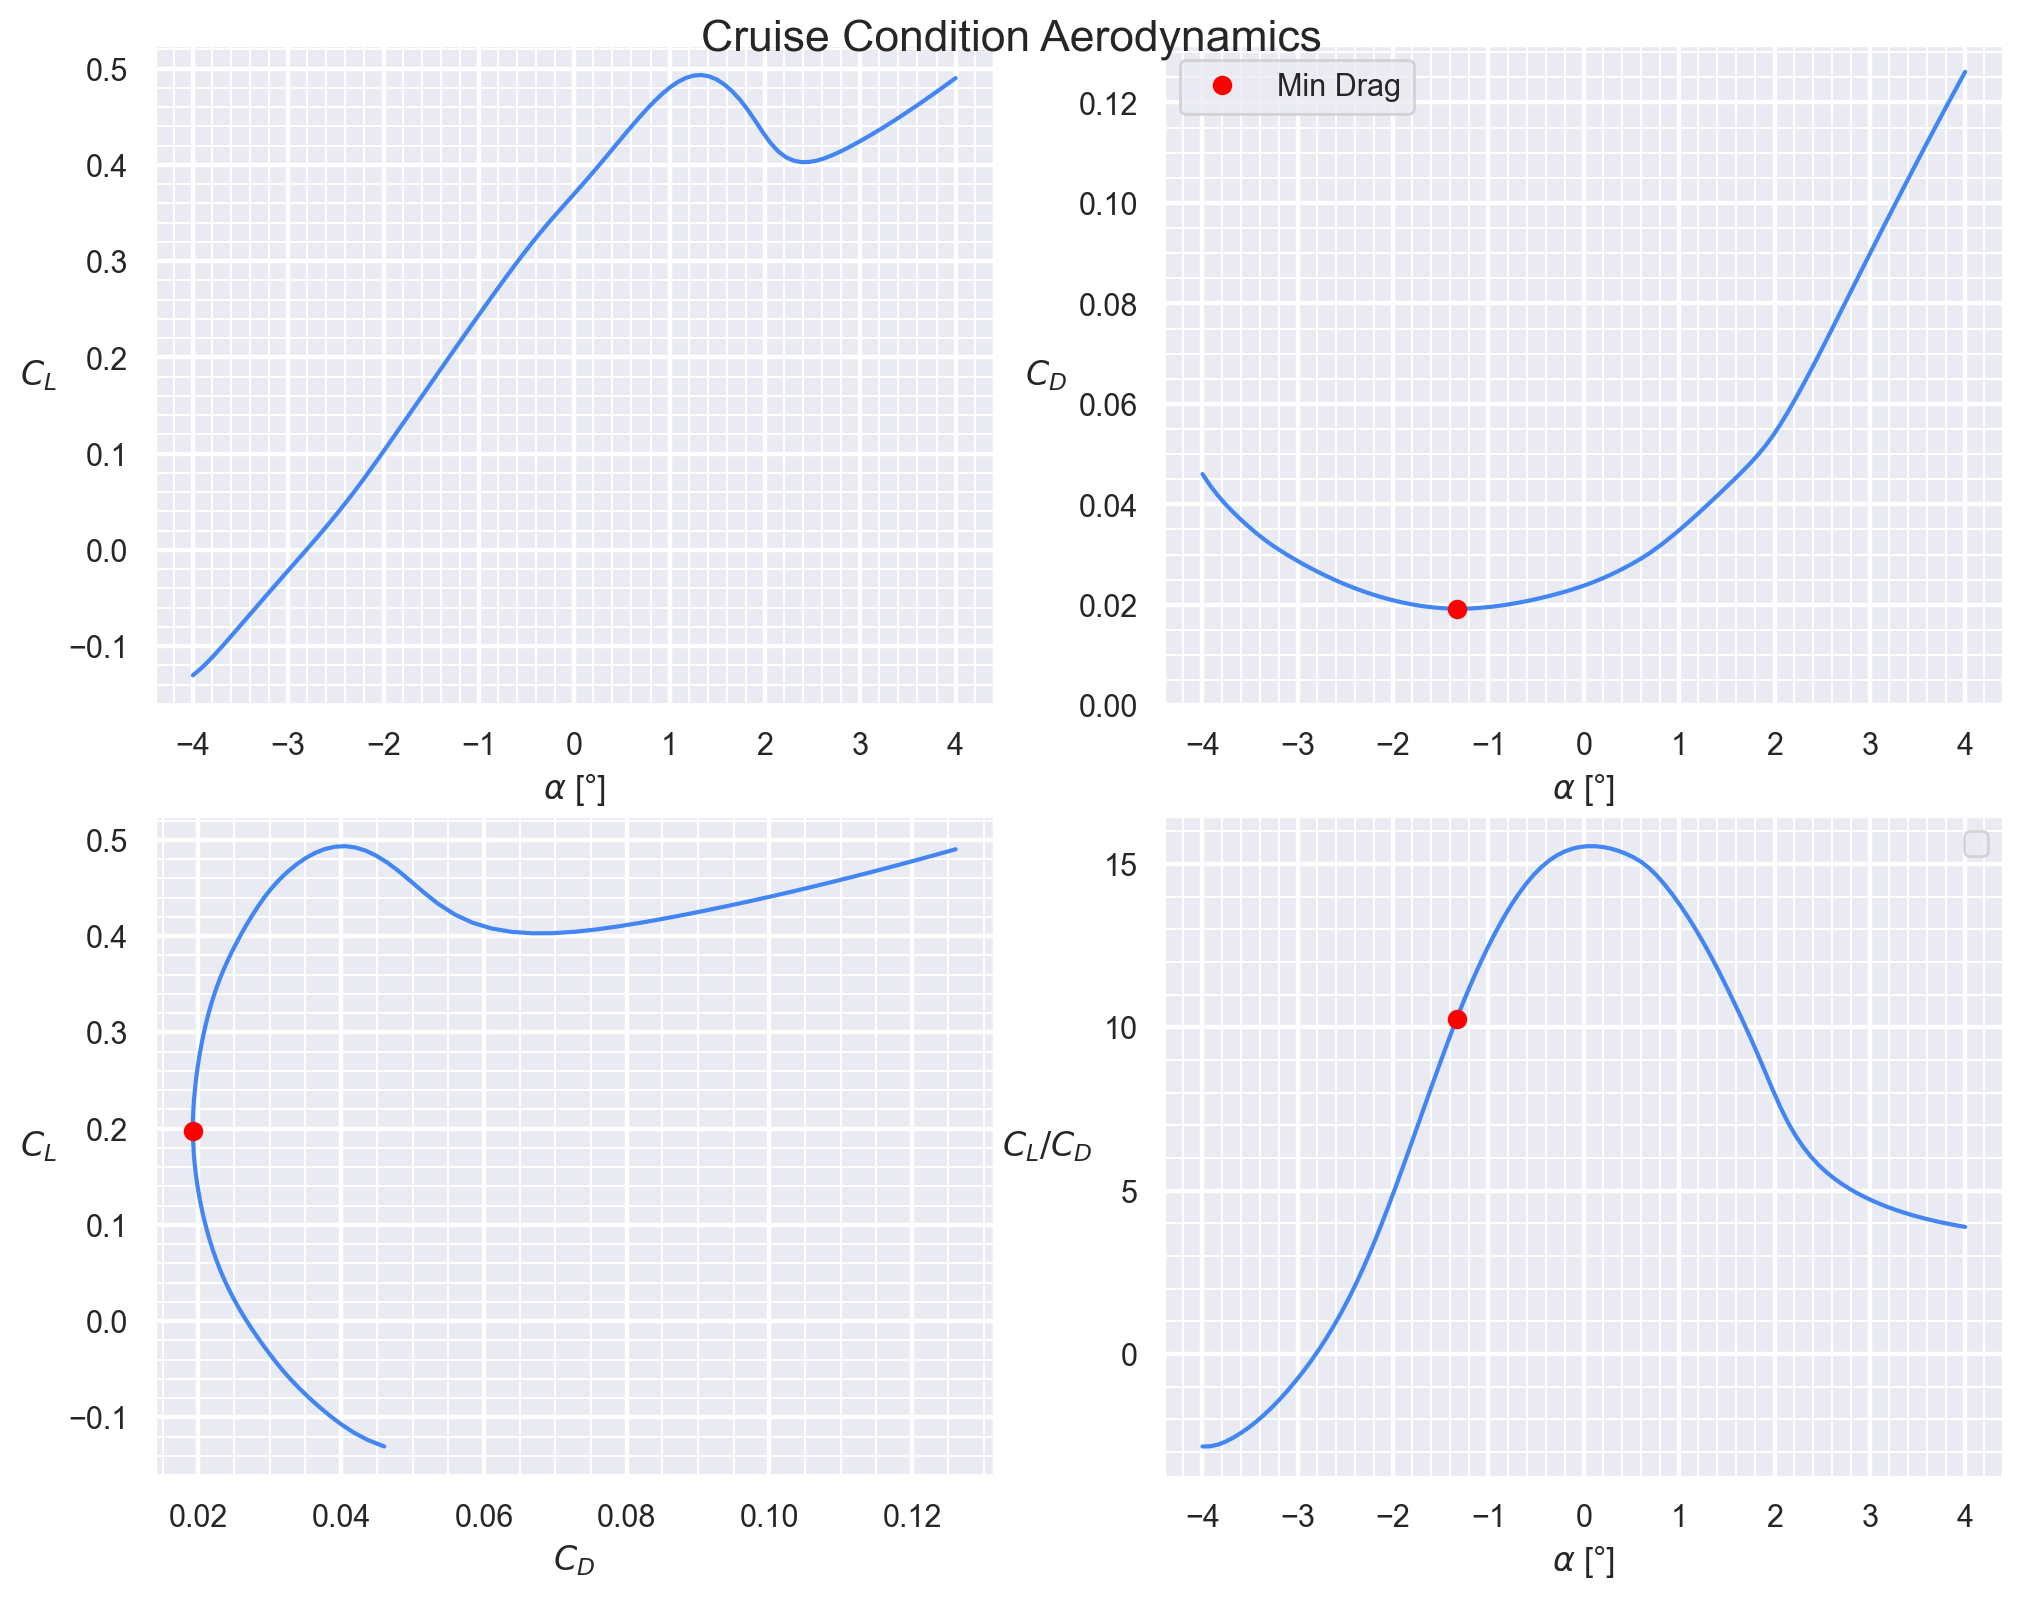

KeyError: 'alpha'

In [6]:
for cond in conditions:
    name = cond["name"]
    alpha_used = cond["alpha"]  # Use the per-condition alpha array
    sol_abu = abu_solutions[name]

    idx_min = np.argmin(sol_abu["CD"])
    cl_min = sol_abu["CL"][idx_min]
    cd_min = sol_abu["CD"][idx_min]

    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    # CL vs alpha
    plt.sca(ax[0, 0])
    plt.plot(alpha_used, sol_abu["CL"])
    plt.xlabel(r"$\alpha$ [°]")
    plt.ylabel(r"$C_L$")
    p.set_ticks(5, 1, 0.5, 0.1)

    # CD vs alpha
    plt.sca(ax[0, 1])
    plt.plot(alpha_used, sol_abu["CD"])
    plt.plot(alpha_used[idx_min], cd_min, 'ro', label="Min Drag")
    plt.xlabel(r"$\alpha$ [°]")
    plt.ylabel(r"$C_D$")
    plt.ylim(bottom=0)
    plt.legend()
    p.set_ticks(5, 1, 0.05, 0.01)

    # CL vs CD
    plt.sca(ax[1, 0])
    plt.plot(sol_abu["CD"], sol_abu["CL"])
    plt.plot(cd_min, cl_min, 'ro')
    plt.xlabel(r"$C_D$")
    plt.ylabel(r"$C_L$")
    p.set_ticks(5, 1, 0.5, 0.1)

    # CL/CD vs alpha
    plt.sca(ax[1, 1])
    plt.plot(alpha_used, sol_abu["CL"] / sol_abu["CD"])
    plt.plot(alpha_used[idx_min], cl_min / cd_min, 'ro')
    plt.xlabel(r"$\alpha$ [°]")
    plt.ylabel(r"$C_L/C_D$")
    p.set_ticks(5, 1, 10, 2)

    fig.suptitle(f"{name} Condition Aerodynamics", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    p.show_plot()








Base S: 0.9509315324230231
Design CL 0.3745279128294945
K0: 0.14800269423565415
K100: 0.018569611074046623
K: 0.02492069411855012
CDi: 0.0007830049639951682

Base S: 0.9432553094000709
Design CL 0.8412825861999724
K0: 0.13049344002362948
K100: 0.018569611074046623
K: 0.024920694118550094
CDi: 0.017877648932752874

Base S: 0.9457430990632996
Design CL 0.8003772753862818
K0: 0.13562537605246064
K100: 0.018569611074046623
K: 0.02492069411855012
CDi: 0.015158888580593105


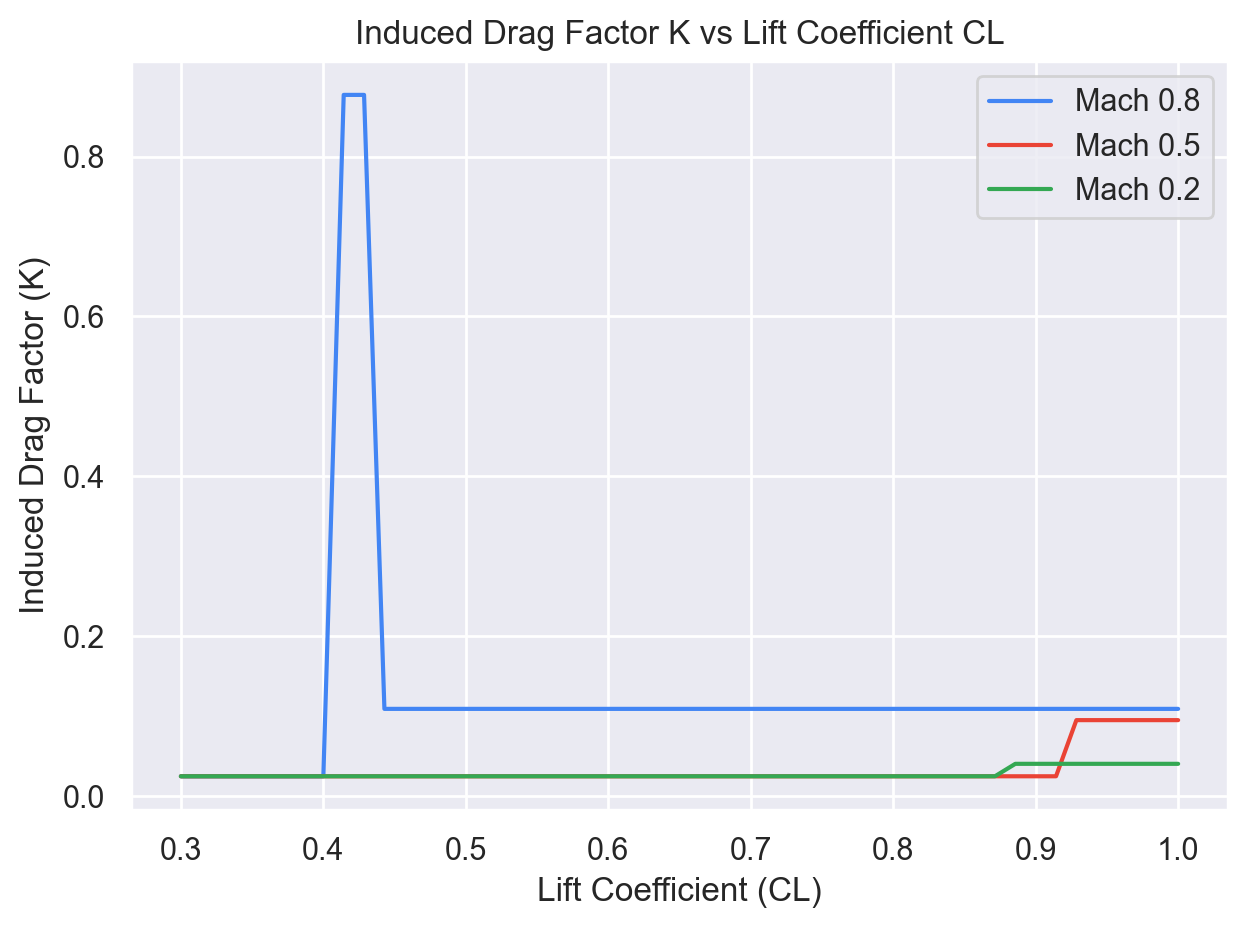

In [219]:
# --- Oswald efficiency using biplane interference ---
def calc_oswald_efficiency(mu, r, sigma):
    num = mu**2 * (1 + r)**2
    den = mu**2 + 2 * sigma * mu * r + r**2
    return num / den

# --- Blending factor S ---
def compute_base_S(e, AR, cl_alpha):
    term = (np.pi * AR) / cl_alpha
    numerator = 1 - e * term
    denominator = e * (1 - term)
    return numerator / denominator

def compute_S(CL, S, CL_design, CL_stall):
    if CL <= 1.1 * CL_design:
        return S
    elif CL <= CL_stall:
        return S - (S - 0.8*S) / (CL_stall - 1.1*CL_design)
    else:
        return 0.8 * CL_design  # Outside valid range


# --- Induced drag factor K ---
def compute_K(S, K0, K100):
    K = S * K100 + (1 - S) * K0
    return K


# --- Geometry inputs (replace with actual values from your model) ---
mu = sol_truss_span / sol_span  # span ratio
r = sol_truss_wing.area(type="wetted") / sol_main_wing.area(type="wetted")
aspect_ratio = sol_span**2 / sol_main_wing.area()
sigma = 0.2  # interference factor
e = calc_oswald_efficiency(mu, r, sigma)


# --- Loop over each condition ---
K_data = []
CL_values = np.linspace(0.3, 1.0, 50)
def get_K_schedule(cond):
    name = cond["name"]
    cl_slope = cond["CL_alpha"]
    cl_clcd_max = cond['CL_CLCD_max']

    # Compute e, S, K
    base_S = compute_base_S(e, aspect_ratio, cl_slope)
    idx_stall = int(cond["alpha_points"] * 0.9) # At righter side of the plots # ! Hacky will need to fix
    stall_cl = abu_solutions[name]["CL"][idx_stall]
    S_values = [compute_S(CL, base_S, cl_clcd_max, stall_cl) for CL in CL_values]

    K_0 = 1 / cl_slope
    K_100 = 1 / (np.pi * aspect_ratio)
    K_values = [compute_K(S, K_0, K_100) for S in S_values]

    print("\nBase S:", base_S)
    print("Design CL", cl_clcd_max)

    print("K0:", K_0)
    print("K100:", K_100)

    # FOR PSET
    S = compute_S(cl_clcd_max, base_S, cl_clcd_max, stall_cl)
    K = compute_K(S, K_0, K_100)
    print("K:", K)
    print("CDi:", K*(cl_clcd_max-cond["CL_min_drag"])**2)

    return K_values


# plt.subplot(1, 2, 2)
plt.plot(CL_values, get_K_schedule(conditions[0]))
plt.plot(CL_values, get_K_schedule(conditions[1]))
plt.plot(CL_values, get_K_schedule(conditions[2]))
plt.legend(["Mach 0.8", "Mach 0.5", "Mach 0.2"])
plt.title("Induced Drag Factor K vs Lift Coefficient CL")
plt.xlabel("Lift Coefficient (CL)")
plt.ylabel("Induced Drag Factor (K)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Filter alpha values greater than 0
cl_takeoff = 2 * weight / (takeoff_atm.density() * sol(main_wing).area() * takeoff_speed**2)
cl_max = takeoff_aero["CL"][225]
cl_delta = cl_takeoff - cl_max
print(takeoff_speed)

# Find the index of cl_max
cl_max_index = np.argmax(takeoff_aero["CL"])
alpha_at_cl_max = takeoff_aero["alpha"][cl_max_index]

print("Alpha at CL max:", alpha_at_cl_max)
print("CL Max (constrained):", cl_max)
print("CL Takeoff:", cl_takeoff)
print("CL Delta:", cl_delta)

In [ ]:
wing_area = main_wing.area()

c_prime_ratio = 1.5 # Typical ratio of c_prime to c_root according to the internet

# Name of Flap Type, [delta_CL, complexity]
flap_types = {"Plain and Split": [0.9, 1],
              "Slatted": [1.3, 1.2],
              "Fowler": [1.3 * c_prime_ratio, 2],
              "Double Slotted": [1.6 * c_prime_ratio, 3],
              "Triple Slotted": [1.9 * c_prime_ratio, 4]
              }

# Name of Leading Edge Flap Type, [delta_CL, complexity]
leading_flap_types = {"Fixed Slot": [0.2, 1],
                      "Leading Edge Flap": [0.3, 1],
                      "Kruger Flap": [0.3, 1.5],
                      "Slat": [0.4 * c_prime_ratio, 2]
                      }

def flap_opti_function(rear_flap_types, lead_flap_types):
    size_weight = 1
    complexity_weight = .25
    combo = []
    eval = []
    s_flap_comp = []
    for rear_flap_type in rear_flap_types:
        for leading_flap_type in lead_flap_types:
            delta_CL = flap_types[rear_flap_type][0] + lead_flap_types[leading_flap_type][0]
            s_flapped_rear = (cl_delta * .8) / (0.9 * rear_flap_types[rear_flap_type][0] * np.cos(np.deg2rad(20)))
            s_flapped_front = (cl_delta * .2) / (0.9 * lead_flap_types[leading_flap_type][0] * np.cos(np.deg2rad(20)))
            complexity = rear_flap_types[rear_flap_type][1] + lead_flap_types[leading_flap_type][1]
            s_flap_comp.append([s_flapped_rear, s_flapped_front, complexity])
            combo.append(rear_flap_type + " + " + leading_flap_type)
            eval.append((size_weight * (s_flapped_rear + s_flapped_front)) + (complexity_weight * complexity))
    return combo, eval, s_flap_comp

In [37]:
# Run optimization function and print results
combo, eval, s_flap_comp = flap_opti_function(flap_types, leading_flap_types)
for c, e in zip(combo, eval):
    print(f"{c}: {round(e, 2)}")
best_index = eval.index(min(eval))
print(f"\nBest combo: {combo[best_index]}")
print("S_flapped of front flap:", round(s_flap_comp[best_index][1],3))
print("S_flapped of rear flap:", round(s_flap_comp[best_index][0],3))
print("Complexity of best combo:", s_flap_comp[best_index][2])


Plain and Split + Fixed Slot: 2.56
Plain and Split + Leading Edge Flap: 2.2
Plain and Split + Kruger Flap: 2.32
Plain and Split + Slat: 2.09
Slatted + Fixed Slot: 2.32
Slatted + Leading Edge Flap: 1.95
Slatted + Kruger Flap: 2.08
Slatted + Slat: 1.84
Fowler + Fixed Slot: 2.29
Fowler + Leading Edge Flap: 1.93
Fowler + Kruger Flap: 2.05
Fowler + Slat: 1.81
Double Slotted + Fixed Slot: 2.46
Double Slotted + Leading Edge Flap: 2.09
Double Slotted + Kruger Flap: 2.22
Double Slotted + Slat: 1.98
Triple Slotted + Fixed Slot: 2.65
Triple Slotted + Leading Edge Flap: 2.29
Triple Slotted + Kruger Flap: 2.41
Triple Slotted + Slat: 2.17

Best combo: Fowler + Slat
S_flapped of front flap: 0.364
S_flapped of rear flap: 0.448
Complexity of best combo: 4
